In [51]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import emd
from scipy import signal
from itertools import cycle
import pandas as pd


In [115]:
# Read the text file into a DataFrame
file_path = 'data/5_edit.txt'
delimiter = ';--:--;'
df = pd.read_csv(file_path, delimiter=delimiter)
df.columns = ['time', 'value']

/var/folders/g8/qb9zv72s0g96lhlhgth8d3ym0000gn/T/ipykernel_79503/548427623.py:4: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  df = pd.read_csv(file_path, delimiter=delimiter)


<Axes: xlabel='time'>

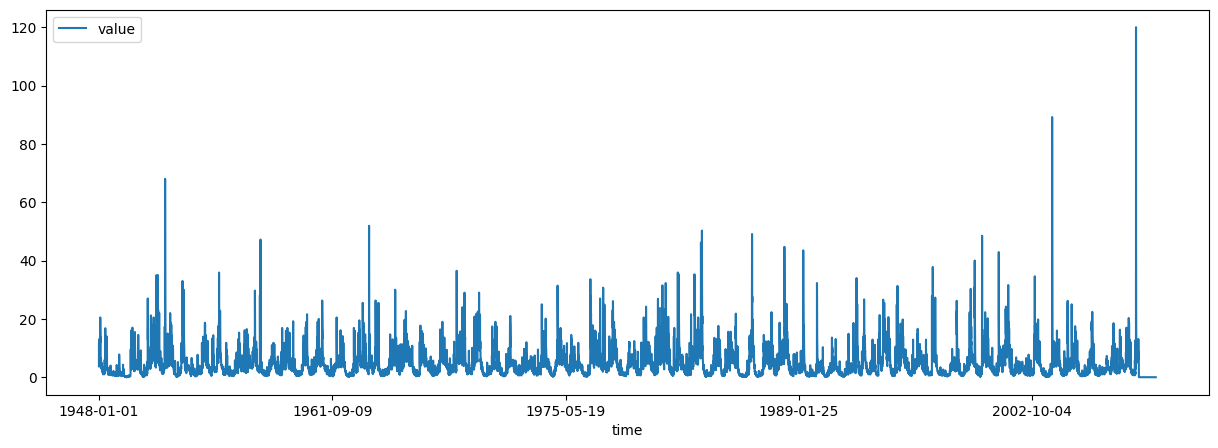

In [79]:
df.plot(x='time', y='value', figsize=(15, 5))

In [81]:
PLOTTED_PERIODS = [2, 4, 8, 16, 32, 64, 128, 256, 512]

In [55]:
data = df['value'].to_numpy()

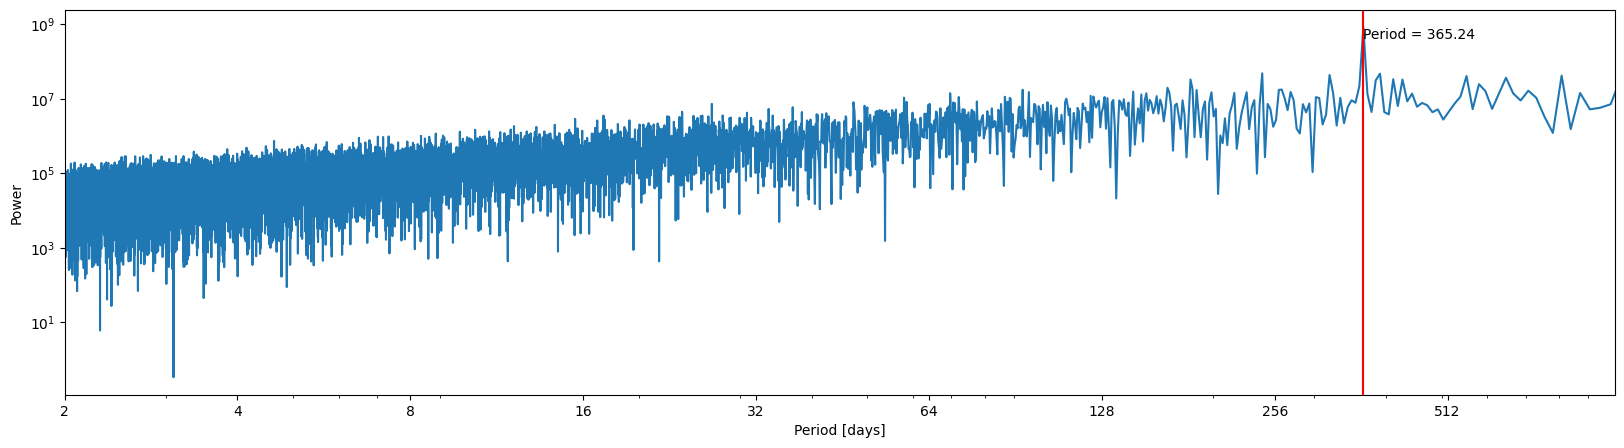

In [82]:
# Calculate the FFT
fft = np.fft.fft(data)
fft = fft[1 : len(fft) // 2]

# Calculate the power spectrum
power_spectrum = np.abs(fft) ** 2

# Calculate the frequencies
sample_freq = np.fft.fftfreq(len(data), d=1)
sample_freq = sample_freq[1 : len(sample_freq) // 2]

# Plot the power spectrum as a function of the period
fig, ax = plt.subplots()
fig.set_size_inches(20, 5)
ax.plot(1 / sample_freq, power_spectrum)

# Plot the highest peak in the power spectrum as a vertical line
max_period = 1 / sample_freq[np.argmax(power_spectrum)]
ax.axvline(max_period, color="red")

# Add text to this line
ax.text(
    max_period,
    0.5 * np.max(power_spectrum),
    "Period = " + str(np.round(max_period, 2))
)
ax.set_xlabel("Period [days]")
ax.set_ylabel("Power")
ax.set_yscale("log")
ax.set_xscale("log")
ax.set_xticks(PLOTTED_PERIODS, PLOTTED_PERIODS)
ax.set_xlim(2, 1000)
plt.show()


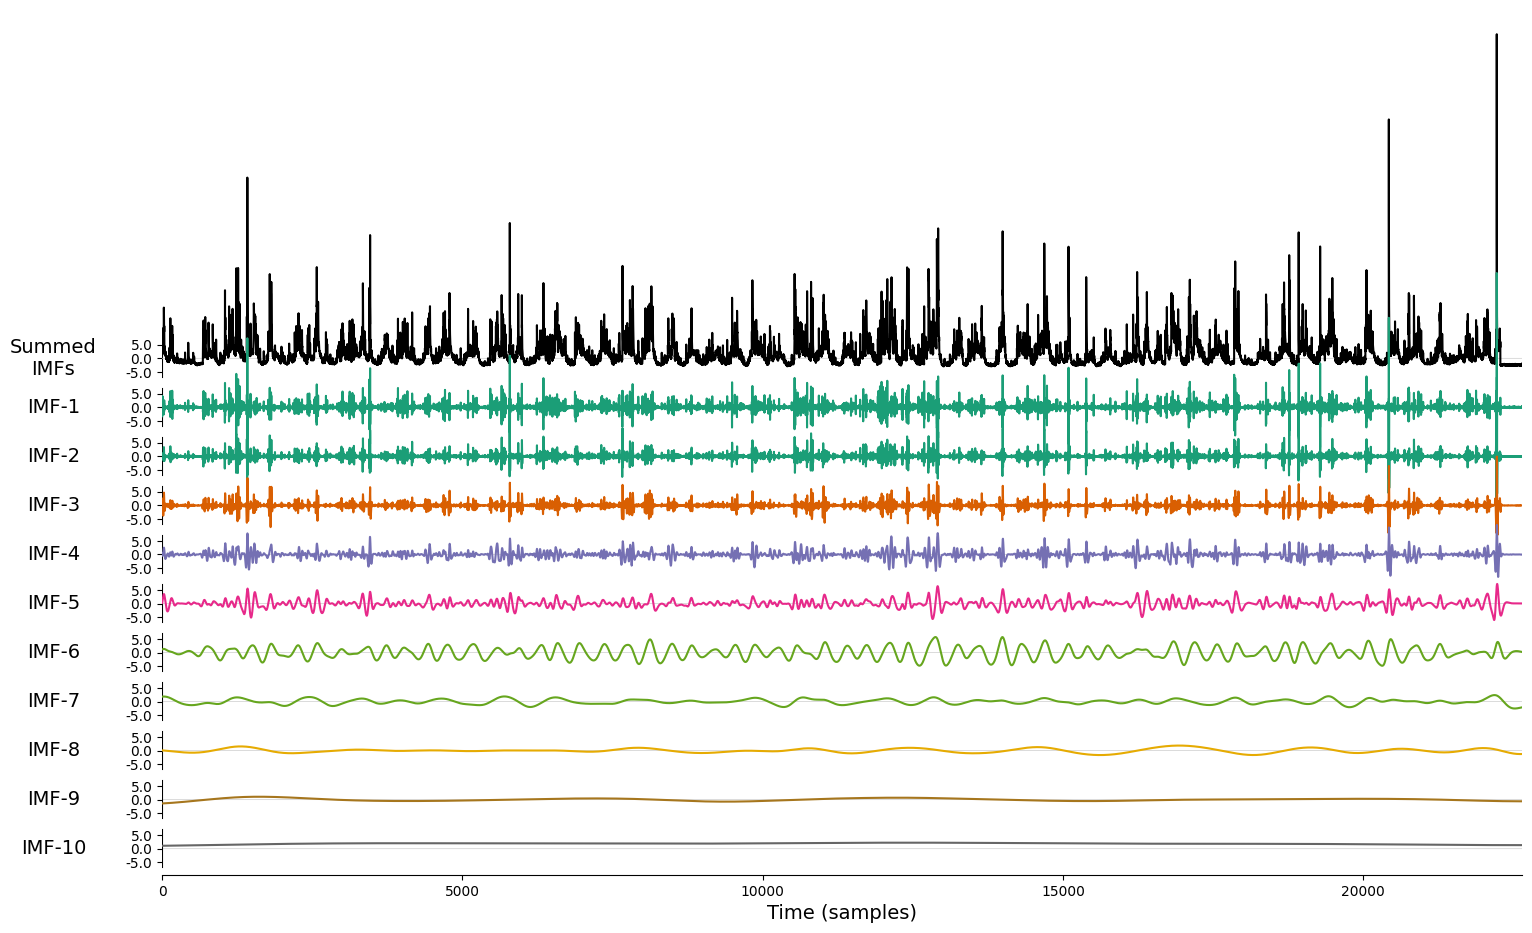

In [58]:
# Calculate the EMD
imf = emd.sift.ensemble_sift(data, max_imfs=10, nensembles=1024, nprocesses=32, ensemble_noise=1)
emd.plotting.plot_imfs(imf)

IP, IF, IA = emd.spectra.frequency_transform(imf, 1, 'hilbert')

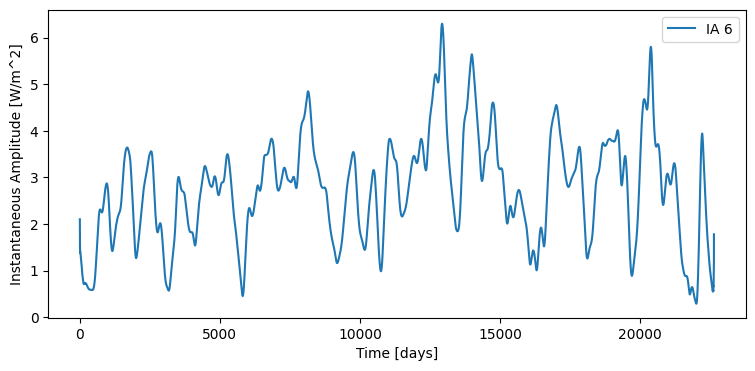

/var/folders/g8/qb9zv72s0g96lhlhgth8d3ym0000gn/T/ipykernel_79503/786675743.py:13: RuntimeWarning: divide by zero encountered in divide
  ax.plot(1 / IF[:, k], label="IF 6")


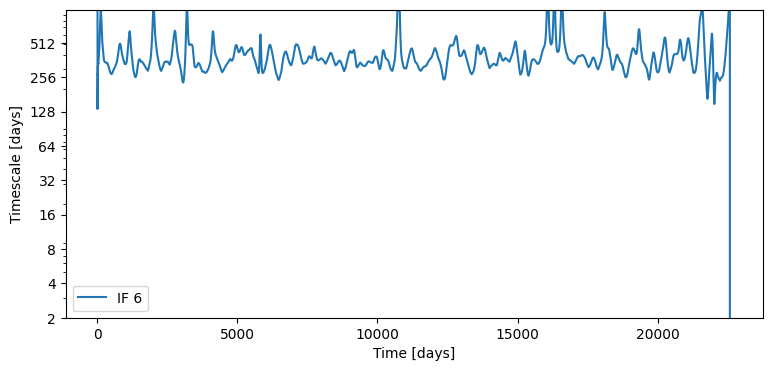

In [83]:
# Plot IA k+1 and IF k+1
k = 5
fig, ax = plt.subplots()
fig.set_size_inches(9, 4)
ax.plot(IA[:, k], label="IA 6")
ax.set_xlabel("Time [days]")
ax.set_ylabel("Instantaneous Amplitude [W/m^2]")
ax.legend()
plt.show()

fig, ax = plt.subplots()
fig.set_size_inches(9, 4)
ax.plot(1 / IF[:, k], label="IF 6")
ax.set_xlabel("Time [days]")
ax.set_ylabel("Timescale [days]")
ax.set_yscale("log")
ax.set_yticks(PLOTTED_PERIODS, PLOTTED_PERIODS)
ax.set_ylim(2, 1000)
ax.legend()
plt.show()


/var/folders/g8/qb9zv72s0g96lhlhgth8d3ym0000gn/T/ipykernel_79503/2802086968.py:10: RuntimeWarning: divide by zero encountered in divide
  ax.plot(1/f, Pxx[i], label="IMF %d" % (i +1), color=color)
/var/folders/g8/qb9zv72s0g96lhlhgth8d3ym0000gn/T/ipykernel_79503/2802086968.py:14: RuntimeWarning: divide by zero encountered in divide
  T = 1/f[::-1]


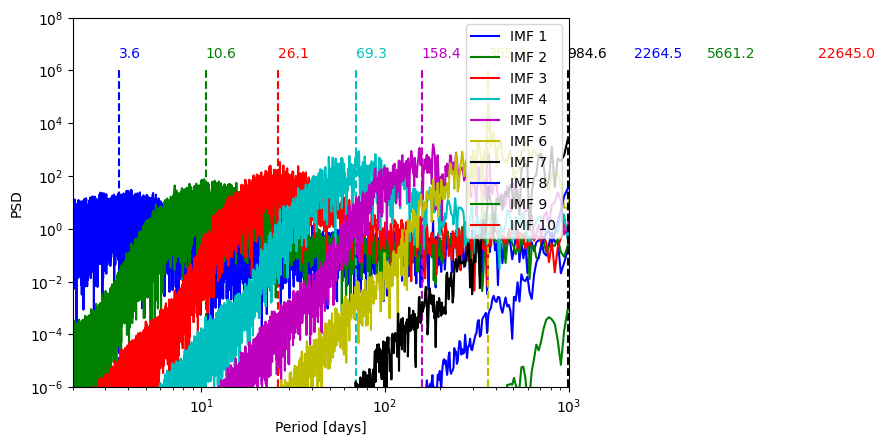

In [85]:
# Compute PSDs of the IMFs
f, Pxx = signal.welch(imf.T, fs=1, nperseg=100000)

COLORS = cycle(["b", "g", "r", "c", "m", "y", "k"])

# Plot the PSDs (x axis is period in days)
fig, ax = plt.subplots()
for i in range(imf.shape[1]):
    color = next(COLORS)
    ax.plot(1/f, Pxx[i], label="IMF %d" % (i +1), color=color)
    # Plot the median of the PSD for each IMF (vline)
    cumsum_T = np.cumsum(Pxx[i, ::-1])
    cumsum_T /= cumsum_T[-1]
    T = 1/f[::-1]
    T = T[cumsum_T > 0.5][0]
    ax.vlines(T, 1e-6, 1e6, color=color, linestyle="--")
    # add text
    ax.text(T, 3e6, "%.1f" % T, color=color)
ax.legend()
ax.set_xlabel("Period [days]")
ax.set_ylabel("PSD")
ax.set_xscale("log")
ax.set_yscale("log")
# limit the y axis
ax.set_ylim(1e-6, 1e8)
ax.set_xlim(2, 1000)
plt.show()

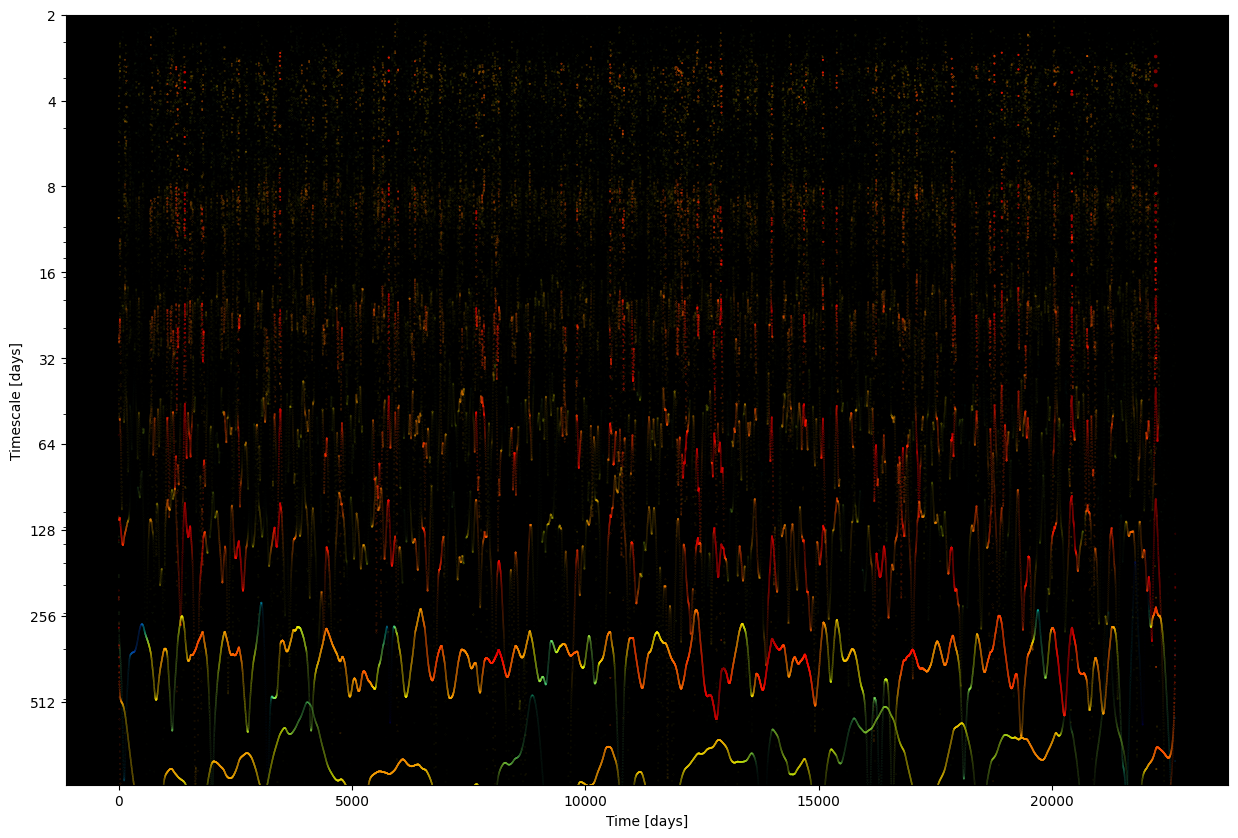

In [86]:
plt.figure(figsize=(15, 10))
# Set background color
plt.rcParams['axes.facecolor'] = "k"
for i in range(imf.shape[1]):
    plt.scatter(np.arange(len(imf)), IF[:, i], c=np.log(IA[:, i]), cmap="jet", s=0.001*IA[:, i]**2, label="IMF %d" % (i +1))
plt.xlabel("Time [days]")
plt.ylabel("Timescale [days]")
plt.yscale("log")
plt.yticks([1/x for x in PLOTTED_PERIODS], PLOTTED_PERIODS)
plt.ylim(1/1000, 1/2)
plt.show()

plt.rcParams['axes.facecolor'] = "w"


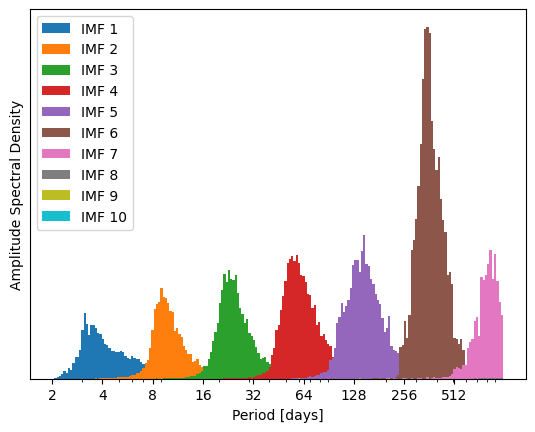

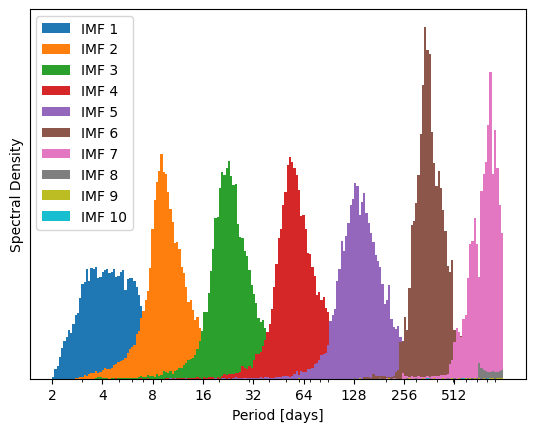

In [87]:
freq_edges, freq_centres = emd.spectra.define_hist_bins(1/1000, 1/2, 200, 'log')

f, hht = emd.spectra.hilberthuang(IF, IA, freq_edges, mode='amplitude', sum_time=True, sum_imfs=False)
f, hht_0a = emd.spectra.hilberthuang(IF, np.ones_like(IA), freq_edges, mode='amplitude', sum_time=True, sum_imfs=False)

# Plot the HHT
for i in range(hht.shape[1]):
    plt.bar(1 / freq_centres, hht[:, i], label="IMF %d" % (i +1), width=1 / freq_edges[1:] - 1 / freq_edges[:-1])
plt.xlabel("Period [days]")
plt.ylabel("Amplitude Spectral Density")
# plt.title("BSRN data from " + paths[i_path])
plt.xscale("log")
plt.xticks(PLOTTED_PERIODS, PLOTTED_PERIODS)
plt.yticks([])
plt.legend()
plt.show()


# Plot the HHT
for i in range(hht.shape[1]):
    plt.bar(1 / freq_centres, hht_0a[:, i], label="IMF %d" % (i +1), width=1 / freq_edges[1:] - 1 / freq_edges[:-1])
plt.xlabel("Period [days]")
plt.ylabel("Spectral Density")
# plt.title("BSRN data from " + paths[i_path])
plt.xscale("log")
plt.xticks(PLOTTED_PERIODS, PLOTTED_PERIODS)
plt.yticks([])
plt.legend()
plt.show()

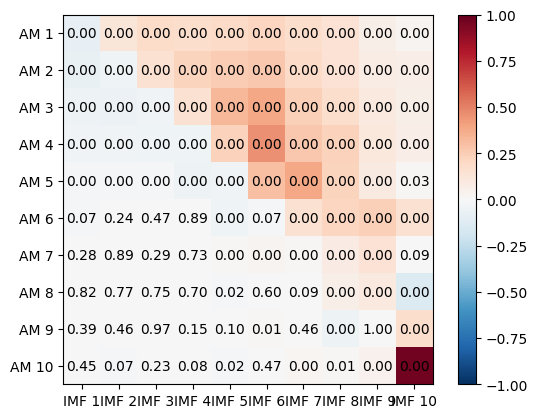

In [88]:
# Compute Kendall's taucorrelation matrix between IA and IMFs
from scipy.stats import kendalltau

taus = np.zeros((imf.shape[1], imf.shape[1]))
ps = np.zeros((imf.shape[1], imf.shape[1]))
for i in range(imf.shape[1]):
    for j in range(imf.shape[1]):
        tau, p = kendalltau(IA[:, i], imf[:, j])
        taus[i, j] = tau
        ps[i, j] = p

# Plot the correlation matrix as a heatmap (p values are written in the cells)
plt.imshow(taus, cmap="RdBu_r", vmin=-1, vmax=1)
for i in range(imf.shape[1]):
    for j in range(imf.shape[1]):
        plt.text(j, i, "%.2f" % ps[i, j], ha="center", va="center")
plt.xticks(np.arange(imf.shape[1]), ["IMF %d" % (i + 1) for i in range(imf.shape[1])])
plt.yticks(np.arange(imf.shape[1]), ["AM %d" % (i + 1) for i in range(imf.shape[1])])
plt.colorbar()
plt.show()

In [110]:
df

,time,value
0,1948-01-01,3.700
1,1948-01-02,11.800
2,1948-01-03,9.600
3,1948-01-04,6.500
4,1948-01-05,6.500
...,...,...
22640,2009-12-26,0.002
22641,2009-12-27,0.002
22642,2009-12-28,0.002
22643,2009-12-29,0.003


In [118]:
df['time'] = pd.to_datetime(df['time'], format='%Y-%m-%d')
df.set_index('time', inplace=True)

In [119]:
df

,value
time,
1948-01-01,3.700
1948-01-02,11.800
1948-01-03,9.600
1948-01-04,6.500
1948-01-05,6.500
...,...
2009-12-26,0.002
2009-12-27,0.002
2009-12-28,0.002


In [120]:
import pandas as pd
import xarray as xr


ds = xr.Dataset.from_dataframe(df)
ds


<xarray.Dataset>
Dimensions:  (time: 22645)
Coordinates:
  * time     (time) datetime64[ns] 1948-01-01 1948-01-02 ... 2009-12-30
Data variables:
    value    (time) float64 3.7 11.8 9.6 6.5 6.5 ... 0.002 0.002 0.003 0.003

In [128]:
resample_rates = np.arange(24, 48, 2)
freq_edges, freq_centres = emd.spectra.define_hist_bins(1/1000, 1/2, 200, 'log')
SWMFs = np.zeros((len(resample_rates), 7))
for i_rr, rr in enumerate(resample_rates):
    freq_ratio = 24 / rr
    ds_resampled = ds["value"].resample(time="{}H".format(rr)).reduce(
        lambda x, axis: np.nanmean(x) if np.isnan(x).sum() < 0.2 * len(x) else np.nan
    )
    ds_resampled = ds_resampled.interpolate_na(dim="time", method="linear")
    print(len(ds_resampled))
    imf = emd.sift.ensemble_sift(ds_resampled.values, max_imfs=7, nensembles=1024, nprocesses=32, ensemble_noise=4)
    IP, IF, IA = emd.spectra.frequency_transform(imf, 1, 'hilbert')
    f, hht = emd.spectra.hilberthuang(IF, IA, freq_edges, mode='amplitude', sum_time=True, sum_imfs=False)
    SWMFs[i_rr, :] = freq_ratio * np.sum(hht * f[:, None], axis=0) / np.sum(hht, axis=0)

22645
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instruct

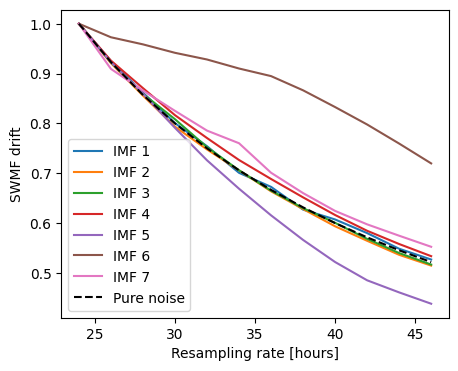

In [129]:
# Plot the SWMFs
plt.figure(figsize=(5, 4))
for i in range(imf.shape[1]):
    plt.plot(resample_rates, SWMFs[:, i] / SWMFs[0, i], label="IMF %d" % (i +1))
# Plot the behaviour of the SWMF for a pure noise signal
plt.plot(resample_rates, 24 / resample_rates, color="black", linestyle="--", label="Pure noise")
plt.xlabel("Resampling rate [hours]")
plt.ylabel("SWMF drift")
# plt.title("BSRN data from " + paths[i_path])
plt.legend()
plt.show()